In [1]:
# --- Célula 1: Importações ---
import pandas as pd
import numpy as np
import joblib
import os
import sys

# Deep Learning (para carregar o modelo LSTM)
import tensorflow as tf
from tensorflow.keras.models import load_model

# Métricas e Visualização
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorar warnings futuros do Tensorflow
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-10-15 14:31:53.186906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-15 14:31:53.204046: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-15 14:31:53.209109: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-15 14:31:53.221767: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-15 14:31:53.947152: W tensorflow/compiler/tf2

In [2]:
# --- Célula 2: Carregamento dos Modelos e Scalers ---
MODEL_DIR = '../models/'

# Carregar modelo LSTM e seu scaler
print("Carregando modelo LSTM...")
model_lstm = load_model(os.path.join(MODEL_DIR, 'best_lstm_model_pos_2017.h5'))
scaler_lstm = joblib.load(os.path.join(MODEL_DIR, 'scaler_lstm_pos_2017.joblib'))

# Carregar modelo XGBoost e seu scaler
print("Carregando modelo XGBoost...")
model_xgb = joblib.load(os.path.join(MODEL_DIR, 'best_xgboost_model_2017.joblib'))
scaler_xgb = joblib.load(os.path.join(MODEL_DIR, 'scaler_xgb_2017.joblib'))

# Carregar modelo BalancedRandomForest e seu scaler
print("Carregando modelo BalancedRandomForest...")
model_brf = joblib.load(os.path.join(MODEL_DIR, 'best_brf_model_2017.joblib'))
scaler_brf = joblib.load(os.path.join(MODEL_DIR, 'scaler_brf_2017.joblib'))

print("\nModelos e scalers carregados com sucesso!")

Carregando modelo LSTM...


I0000 00:00:1760549535.687723  240527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760549535.734542  240527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760549535.737546  240527 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1760549535.741625  240527 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Carregando modelo XGBoost...
Carregando modelo BalancedRandomForest...

Modelos e scalers carregados com sucesso!


In [3]:
# --- Célula 3: Carregamento e Preparação dos Dados ---

# Carrega a tabela de modelagem completa
path_final_table = '../data/processed/modeling_table_final.parquet'
df_completo = pd.read_parquet(path_final_table)

# --- Definição das Features (Cenário Pós-2017) ---
features_hidrica = ['ear_percentual_seco', 'ena_percentual_mlt_seco']
features_adicionais = ['cmo_semanal_seco', 'disponibilidade_total_diaria_go', 'indicador_ccal_mensal']
features_clima = ['ghi', 'temp2m_c', 'precipitacao_mm']
features_avancadas = ['carga_media_7d','carga_std_7d','geracao_media_7d','ear_ontem','ear_diff_3d','margem_oferta_demanda','pressao_demanda_ear','precip_acumulada_14d','precip_acumulada_30d']
features_calendario = ['mes','dia_da_semana','dia_do_ano']
features_para_teste_nomes = features_hidrica + features_adicionais + features_clima + features_calendario + features_avancadas

# --- Filtragem e Split dos Dados ---
sys.path.append('..')
from config import END_YEAR
START_YEAR = 2017
CENARIO_ESCOLHIDO = 'pos_2017'
nome_cenario = f"Ensemble Pós-{START_YEAR}"

anos_de_interesse = range(START_YEAR, END_YEAR + 1)
df = df_completo[df_completo.index.year.isin(anos_de_interesse)].copy()

features_para_teste = [col for col in features_para_teste_nomes if col in df.columns]
X = df[features_para_teste]
y = df['nivel_risco']

# Mapeamento do alvo
mapeamento_risco = {'baixo': 0, 'medio': 1, 'alto': 2}
y_encoded = y.map(mapeamento_risco)

# Split temporal (mesma lógica do notebook LSTM)
test_size = 0.2
split_index = int(len(X) * (1 - test_size))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y_encoded[:split_index], y_encoded[split_index:]

print(f"Dados de teste preparados: {X_test.shape[0]} amostras.")

Dados de teste preparados: 636 amostras.


In [4]:
# --- Célula 4: Gerar Previsões de Cada Modelo ---

# 1. Previsão do LSTM (requer dados em sequência)
# --------------------------------------------------
TIME_STEPS = 14

# Função para criar sequências, igual à do notebook de treino
def create_sequences(X_data, y_data, time_steps=14):
    Xs, ys = [], []
    for i in range(len(X_data) - time_steps):
        Xs.append(X_data[i:(i + time_steps)])
        ys.append(y_data[i + time_steps])
    return np.array(Xs), np.array(ys)

# Normaliza os dados de teste com o scaler do LSTM
X_test_scaled_lstm = scaler_lstm.transform(X_test)

# Cria as sequências e o y_test correspondente
X_test_seq, y_test_seq = create_sequences(X_test_scaled_lstm, y_test.values, TIME_STEPS)

# Gera as probabilidades
y_pred_proba_lstm = model_lstm.predict(X_test_seq)

print(f"Previsões LSTM geradas. Formato: {y_pred_proba_lstm.shape}")
print(f"Labels de teste alinhados (y_test_seq). Formato: {y_test_seq.shape}")

# 2. Previsões do XGBoost e BalancedRandomForest (dados tabulares)
# ------------------------------------------------------------------

# Precisamos usar os dados de teste a partir do 15º dia para alinhar com o LSTM
X_test_flat_aligned = X_test.iloc[TIME_STEPS:]

# Normaliza com os respectivos scalers
X_test_scaled_xgb = scaler_xgb.transform(X_test_flat_aligned)
X_test_scaled_brf = scaler_brf.transform(X_test_flat_aligned)

# Gera as probabilidades
y_pred_proba_xgb = model_xgb.predict_proba(X_test_scaled_xgb)
y_pred_proba_brf = model_brf.predict_proba(X_test_scaled_brf)

print(f"Previsões XGBoost geradas. Formato: {y_pred_proba_xgb.shape}")
print(f"Previsões BalancedRF geradas. Formato: {y_pred_proba_brf.shape}")

11/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step   

2025-10-15 14:32:46.553248: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Previsões LSTM geradas. Formato: (622, 3)
Labels de teste alinhados (y_test_seq). Formato: (622,)
Previsões XGBoost geradas. Formato: (622, 3)
Previsões BalancedRF geradas. Formato: (622, 3)



--- Resultados Finais do Modelo Ensemble ---
              precision    recall  f1-score   support

       baixo       1.00      1.00      1.00       615
       medio       0.80      0.80      0.80         5
        alto       0.67      1.00      0.80         2

    accuracy                           1.00       622
   macro avg       0.82      0.93      0.87       622
weighted avg       1.00      1.00      1.00       622



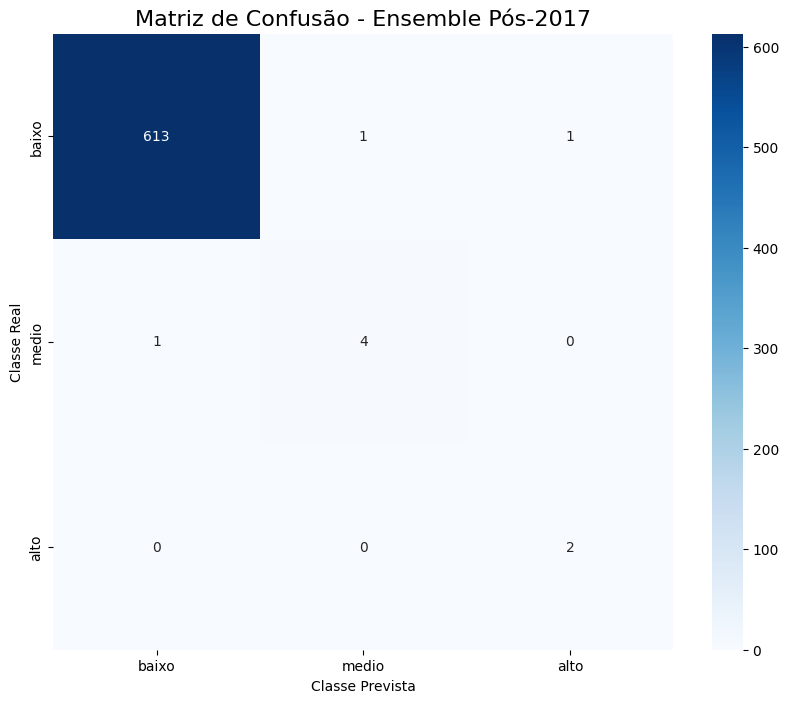

In [5]:
# --- Célula 5: Ensemble por Média e Avaliação Final ---

# Média simples das probabilidades
y_pred_proba_ensemble = (y_pred_proba_lstm + y_pred_proba_xgb + y_pred_proba_brf) / 3.0

# A previsão final é a classe com a maior probabilidade média
y_pred_ensemble = np.argmax(y_pred_proba_ensemble, axis=1)

print(f"\n--- Resultados Finais do Modelo Ensemble ---")
print(classification_report(
    y_test_seq, 
    y_pred_ensemble, 
    target_names=mapeamento_risco.keys(), 
    zero_division=0
))

# Matriz de Confusão para o Ensemble
cm_ensemble = confusion_matrix(y_test_seq, y_pred_ensemble)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm_ensemble, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=mapeamento_risco.keys(),
    yticklabels=mapeamento_risco.keys()
)
plt.title(f'Matriz de Confusão - {nome_cenario}', fontsize=16)
plt.ylabel('Classe Real')
plt.xlabel('Classe Prevista')
plt.show()